In [9]:
from sklearnex import patch_sklearn
patch_sklearn()

import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import pandas as pd
import pickle
import os

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.base import BaseEstimator, TransformerMixin, clone

from sklearn.feature_selection import SelectFromModel
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as skLDA

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn import set_config

from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import random
from deap import base, creator, tools, algorithms

import multiprocessing

from cuml.svm import LinearSVC as cuSVC
from cuml import LogisticRegression as cuLR
from cuml.neighbors import KNeighborsClassifier as cuKNN
from cuml.ensemble import RandomForestClassifier as cuRF
from cuml.naive_bayes import GaussianNB as cuNB
from sklearn.naive_bayes import GaussianNB as skNB
from sklearn.ensemble import RandomForestClassifier as skRF
from sklearn.neighbors import KNeighborsClassifier as skKNN
from sklearn.svm import LinearSVC as skSVC
from sklearn.linear_model import LogisticRegression as skLR

import shap

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
/home/arisingh/mambaforge/envs/ccd/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class FeatureSetChromosome(object):
    def __init__(self, genes, size):
        self.genes = np.random.choice(genes, size)
    
    def get_genes(self):
        return self.genes
    
    def __len__(self):
        return len(self.genes)
    
    def __iter__(self):
        yield from self.genes
    
    def __getitem__(self, key):
        return self.genes[key]
    
    def __setitem__(self, key, data):
        self.genes[key] = data

# setting individual creator
creator.create('FitnessMulti', base.Fitness, weights=(1, -1))
creator.create('Individual', FeatureSetChromosome, fitness=creator.FitnessMulti)

def mutate(individual, pb=0):
    # maximal amount of mutated genes
    n_mutated_max = max(1, int(len(individual) * pb))
    # generate the random amount of mutated genes
    n_mutated = random.randint(1, n_mutated_max)
    # select random genes which need to be mutated
    mutated_indexes = random.sample(list(range(len(individual))), n_mutated)
    # mutation
    for index in mutated_indexes:
        individual[index] = 0 if individual[index] else 1 # flip between 0s and 1s
    return individual,

def evaluate(individual, model, X, y, n_splits=3):
    features = [name for name, selected in zip(list(X.columns), individual.get_genes()) if selected == 1]
    clf = clone(model)
    folds = cross_val_score(
        clf, 
        X[features], 
        y, 
        cv=n_splits,
        scoring='roc_auc_ovr_weighted')
    return folds.mean(), sum(individual.get_genes())

class GATransformer(BaseEstimator, TransformerMixin):
    def __init__(self, model):   
        self.model = model
    
    def fit(self, X, y=None):
        self.feature_names_in_ = list(X.columns)
        
        def init_individual(ind_class, genes=None, size=None):
            return ind_class(genes, size)
        
        toolbox = base.Toolbox()
        
        n_features = len(X.columns)
        toolbox.register(
            'individual', init_individual, creator.Individual,
            genes=[0, 1], size=n_features)
        toolbox.register(
            'population', tools.initRepeat, list, toolbox.individual)

        # raise population
        self.pop = toolbox.population(10)

        toolbox.register('mate', tools.cxTwoPoint)
        toolbox.register('mutate', mutate, pb=0.2)
        toolbox.register('evaluate', evaluate, model=self.model, X=X, y=y, n_splits=3)
        toolbox.register('select', tools.selNSGA2)
        
        pool = multiprocessing.Pool()
        toolbox.register("map", pool.map)
        
        auc_stats = tools.Statistics(key=lambda ind: ind.fitness.values[0])
        n_feat_stats = tools.Statistics(key=lambda ind: ind.fitness.values[1])
        mstats = tools.MultiStatistics(auc=auc_stats, n_features=n_feat_stats)
        mstats.register("mean", np.mean)
        mstats.register("max", max)
        mstats.register("min", min)

        hof = tools.HallOfFame(3)
        result, logbook = algorithms.eaMuPlusLambda(
            self.pop, toolbox,
            mu=10, lambda_=30, cxpb=0.5, mutpb=0.5,
            ngen=40, stats=mstats, halloffame=hof, verbose=True)
        
        split = 0
        while os.path.exists(f"logbooks/{type(self.model).__name__}-split{split}"):
            split += 1

        with open(f"logbooks/{type(self.model).__name__}-split{split}", "wb") as outfile:
            pickle.dump(logbook, outfile, protocol=pickle.HIGHEST_PROTOCOL)

        fig, ax1 = plt.subplots()

        ax1.set_xlabel('Number of generations')
        ax1.set_ylabel('AUC')
        ax1.plot(logbook.chapters['auc'].select("gen"), logbook.chapters['auc'].select("max"), label="Max AUC")

        ax2 = ax1.twinx()
        ax2.set_ylabel('Number of features')
        ax2.plot(logbook.chapters['n_features'].select("gen"), logbook.chapters['n_features'].select("min"), label="Min features")

        fig.suptitle(f'GA Transformer Evolution: {self.model}')
        fig.legend()
        fig.tight_layout()
        
        plt.show()
        
        self.best_features = hof[0].get_genes()
        return self
    
    def get_feature_names_out(self, input_features=None):
        if input_features is not None:
            return [name for name, selected in zip(input_features, self.best_features) if selected == 1]
        else:
            return [name for name, selected in zip(self.feature_names_in_, self.best_features) if selected == 1]
        
    def transform(self, X, y=None):
        features = [name for name, selected in zip(list(X.columns), self.best_features) if selected == 1]
        return X[features]
    
    def get_params(self, deep=True):
        return {"model": self.model}
    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

In [3]:
df = pd.read_csv("data/CCD-INIDv1/multiclass_data.csv")
X_data = df.drop(['id', 'atk_type'], axis=1)
y_data = df['atk_type']

In [4]:
def custom_scorer(clf, X, y):
    y_pred = clf.predict(X)
    return {
        "accuracy": accuracy_score(y, y_pred),
        "precision": precision_score(y, y_pred, average="macro"),
        "recall": recall_score(y, y_pred, average="macro"),
        "roc_auc_score": roc_auc_score(y, clf.predict_proba(X), average="weighted", multi_class="ovr"),
        "n_features_in": len(X.columns) if clf['fs']=="passthrough" else len(clf['fs'].get_feature_names_out())
    }

In [5]:
set_config(transform_output="pandas")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5; 1/30] START classify=GaussianNB(), fs=passthrough......................
[CV 1/5; 1/30] END classify=GaussianNB(), fs=passthrough; accuracy: (test=0.974) n_features_in: (test=81.000) precision: (test=0.969) recall: (test=0.965) roc_auc_score: (test=0.987) total time=   0.4s
[CV 2/5; 1/30] START classify=GaussianNB(), fs=passthrough......................
[CV 2/5; 1/30] END classify=GaussianNB(), fs=passthrough; accuracy: (test=0.994) n_features_in: (test=81.000) precision: (test=0.992) recall: (test=0.987) roc_auc_score: (test=0.999) total time=   0.3s
[CV 3/5; 1/30] START classify=GaussianNB(), fs=passthrough......................
[CV 3/5; 1/30] END classify=GaussianNB(), fs=passthrough; accuracy: (test=0.991) n_features_in: (test=81.000) precision: (test=0.988) recall: (test=0.982) roc_auc_score: (test=0.999) total time=   0.4s
[CV 4/5; 1/30] START classify=GaussianNB(), fs=passthrough......................
[CV 4/5;

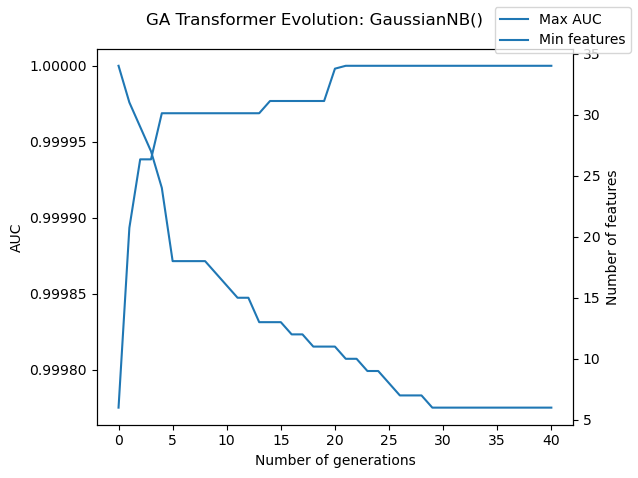

[CV 1/5; 2/30] END classify=GaussianNB(), fs=GATransformer(model=GaussianNB()); accuracy: (test=0.966) n_features_in: (test=6.000) precision: (test=0.962) recall: (test=0.952) roc_auc_score: (test=0.986) total time= 2.1min
[CV 2/5; 2/30] START classify=GaussianNB(), fs=GATransformer(model=GaussianNB())
   	      	                             auc                              	              n_features              
   	      	--------------------------------------------------------------	--------------------------------------
gen	nevals	gen	max     	mean    	min     	nevals	gen	max	mean	min	nevals
0  	10    	0  	0.996402	0.969007	0.725732	10    	0  	48 	41  	35 	10    
1  	30    	1  	0.996509	0.996261	0.995959	30    	1  	47 	39.1	34 	30    
2  	30    	2  	0.996547	0.99643 	0.99627 	30    	2  	44 	37.7	32 	30    
3  	30    	3  	0.996594	0.996467	0.996328	30    	3  	44 	35.5	29 	30    
4  	30    	4  	0.996596	0.996494	0.996362	30    	4  	41 	32.3	28 	30    
5  	30    	5  	0.996688	0.996586

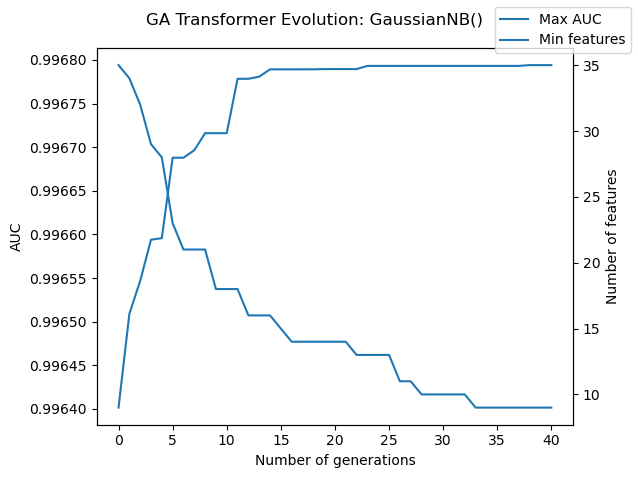

[CV 2/5; 2/30] END classify=GaussianNB(), fs=GATransformer(model=GaussianNB()); accuracy: (test=0.997) n_features_in: (test=10.000) precision: (test=0.996) recall: (test=0.993) roc_auc_score: (test=1.000) total time= 2.3min
[CV 3/5; 2/30] START classify=GaussianNB(), fs=GATransformer(model=GaussianNB())
   	      	                             auc                              	              n_features              
   	      	--------------------------------------------------------------	--------------------------------------
gen	nevals	gen	max     	mean    	min     	nevals	gen	max	mean	min	nevals
0  	10    	0  	0.996558	0.946917	0.743148	10    	0  	49 	42.3	31 	10    
1  	30    	1  	0.996648	0.99649 	0.99609 	30    	1  	44 	35.7	29 	30    
2  	30    	2  	0.996648	0.996546	0.996446	30    	2  	38 	33.1	27 	30    
3  	30    	3  	0.996648	0.996568	0.996446	30    	3  	38 	31.5	26 	30    
4  	30    	4  	0.996692	0.996619	0.996542	30    	4  	38 	30  	22 	30    
5  	30    	5  	0.996755	0.99665

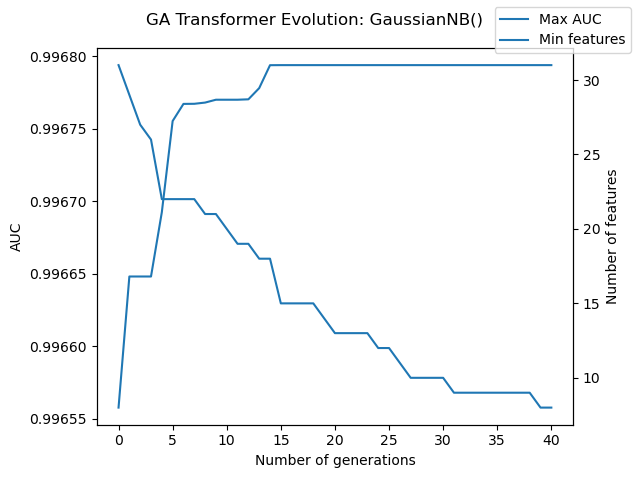

[CV 3/5; 2/30] END classify=GaussianNB(), fs=GATransformer(model=GaussianNB()); accuracy: (test=1.000) n_features_in: (test=9.000) precision: (test=1.000) recall: (test=1.000) roc_auc_score: (test=1.000) total time= 2.4min
[CV 4/5; 2/30] START classify=GaussianNB(), fs=GATransformer(model=GaussianNB())
   	      	                             auc                              	              n_features              
   	      	--------------------------------------------------------------	--------------------------------------
gen	nevals	gen	max     	mean    	min     	nevals	gen	max	mean	min	nevals
0  	10    	0  	0.996469	0.995699	0.994707	10    	0  	46 	40.5	31 	10    
1  	30    	1  	0.996474	0.996089	0.995534	30    	1  	43 	36.7	31 	30    
2  	30    	2  	0.996507	0.996293	0.995561	30    	2  	42 	35.8	30 	30    
3  	30    	3  	0.996583	0.996149	0.995401	30    	3  	42 	33.8	29 	30    
4  	30    	4  	0.996583	0.996367	0.995914	30    	4  	41 	34.1	25 	30    
5  	30    	5  	0.996677	0.996307

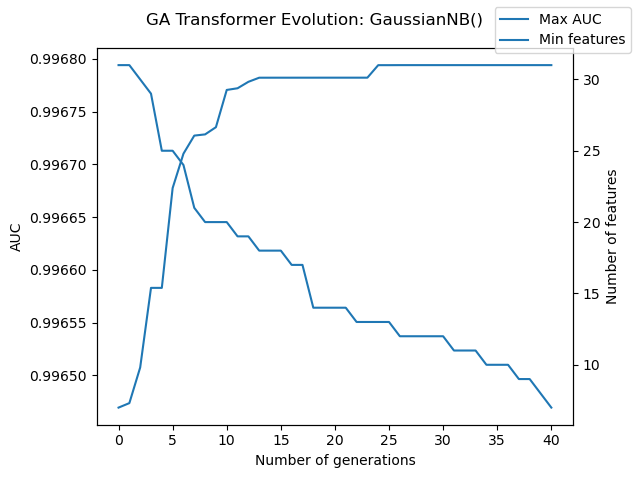

[CV 4/5; 2/30] END classify=GaussianNB(), fs=GATransformer(model=GaussianNB()); accuracy: (test=1.000) n_features_in: (test=7.000) precision: (test=1.000) recall: (test=1.000) roc_auc_score: (test=1.000) total time= 2.4min
[CV 5/5; 2/30] START classify=GaussianNB(), fs=GATransformer(model=GaussianNB())
   	      	                             auc                              	              n_features              
   	      	--------------------------------------------------------------	--------------------------------------
gen	nevals	gen	max     	mean    	min     	nevals	gen	max	mean	min	nevals
0  	10    	0  	0.996611	0.995902	0.995046	10    	0  	52 	42.8	35 	10    
1  	30    	1  	0.996611	0.99629 	0.995728	30    	1  	44 	38.4	35 	30    
2  	30    	2  	0.996627	0.996525	0.996234	30    	2  	44 	37.1	34 	30    
3  	30    	3  	0.996701	0.996596	0.996218	30    	3  	41 	36.6	32 	30    
4  	30    	4  	0.996701	0.996528	0.995703	30    	4  	42 	34.9	31 	30    
5  	30    	5  	0.996726	0.996644

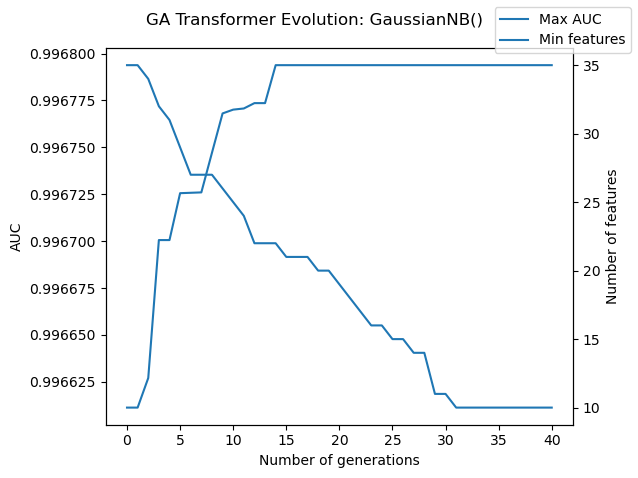

[CV 5/5; 2/30] END classify=GaussianNB(), fs=GATransformer(model=GaussianNB()); accuracy: (test=0.997) n_features_in: (test=11.000) precision: (test=0.996) recall: (test=0.994) roc_auc_score: (test=1.000) total time= 2.3min
[CV 1/5; 3/30] START classify=GaussianNB(), fs=GATransformer(model=LinearDiscriminantAnalysis())
   	      	                     auc                      	              n_features              
   	      	----------------------------------------------	--------------------------------------
gen	nevals	gen	max	mean   	min     	nevals	gen	max	mean	min	nevals
0  	10    	0  	1  	0.98288	0.828991	10    	0  	59 	40  	32 	10    
1  	30    	1  	1  	0.982871	0.828753	30    	1  	41 	34.8	31 	30    
2  	30    	2  	1  	0.999997	0.999991	30    	2  	41 	34.2	30 	30    
3  	30    	3  	1  	0.999998	0.999992	30    	3  	35 	32.2	29 	30    
4  	30    	4  	1  	0.999999	0.999993	30    	4  	33 	30.2	27 	30    
5  	30    	5  	1  	1       	0.999996	30    	5  	30 	28  	25 	30    
6  	30    	

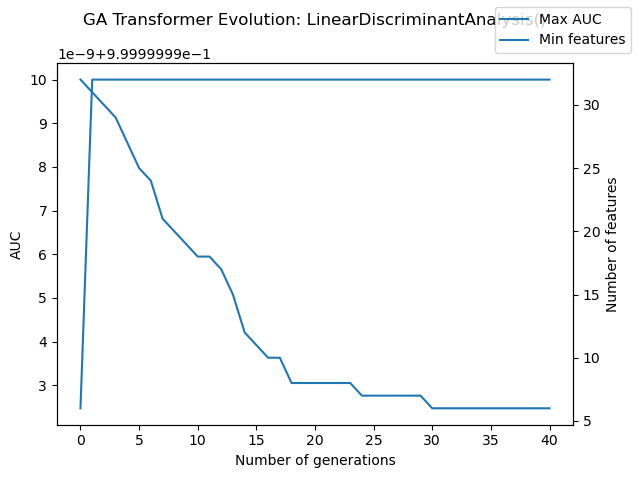

[CV 1/5; 3/30] END classify=GaussianNB(), fs=GATransformer(model=LinearDiscriminantAnalysis()); accuracy: (test=0.977) n_features_in: (test=6.000) precision: (test=0.972) recall: (test=0.970) roc_auc_score: (test=0.986) total time= 4.8min
[CV 2/5; 3/30] START classify=GaussianNB(), fs=GATransformer(model=LinearDiscriminantAnalysis())
   	      	                             auc                              	              n_features              
   	      	--------------------------------------------------------------	--------------------------------------
gen	nevals	gen	max     	mean    	min     	nevals	gen	max	mean	min	nevals
0  	10    	0  	0.998357	0.997712	0.996862	10    	0  	49 	41.4	34 	10    
1  	30    	1  	0.998357	0.997911	0.997126	30    	1  	44 	37.1	33 	30    
2  	30    	2  	0.99838 	0.998081	0.997264	30    	2  	43 	35.4	30 	30    
3  	30    	3  	0.99841 	0.998172	0.997759	30    	3  	41 	34.2	30 	30    
4  	30    	4  	0.998411	0.998294	0.998019	30    	4  	40 	32.9	29 	30    


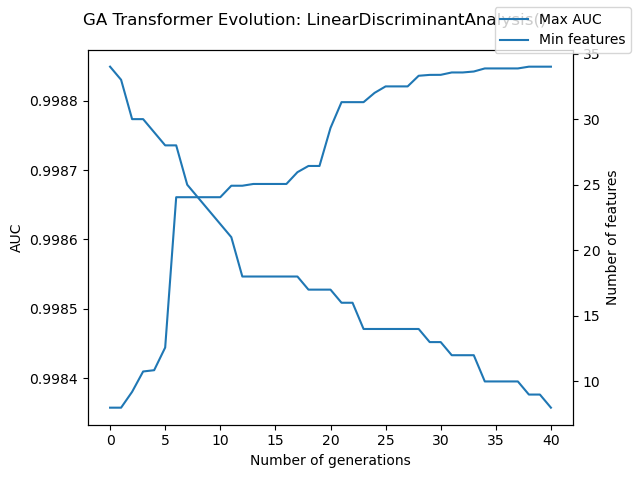

[CV 2/5; 3/30] END classify=GaussianNB(), fs=GATransformer(model=LinearDiscriminantAnalysis()); accuracy: (test=0.999) n_features_in: (test=8.000) precision: (test=0.999) recall: (test=0.999) roc_auc_score: (test=1.000) total time= 5.8min
[CV 3/5; 3/30] START classify=GaussianNB(), fs=GATransformer(model=LinearDiscriminantAnalysis())
   	      	                             auc                              	              n_features              
   	      	--------------------------------------------------------------	--------------------------------------
gen	nevals	gen	max     	mean    	min     	nevals	gen	max	mean	min	nevals
0  	10    	0  	0.998196	0.978207	0.800027	10    	0  	46 	40.5	30 	10    
1  	30    	1  	0.998509	0.998084	0.997418	30    	1  	44 	37.3	30 	30    
2  	30    	2  	0.998509	0.998137	0.997418	30    	2  	41 	34.2	29 	30    
3  	30    	3  	0.998509	0.977248	0.788718	30    	3  	42 	32.4	26 	30    
4  	30    	4  	0.998542	0.977308	0.788718	30    	4  	38 	31.3	26 	30    


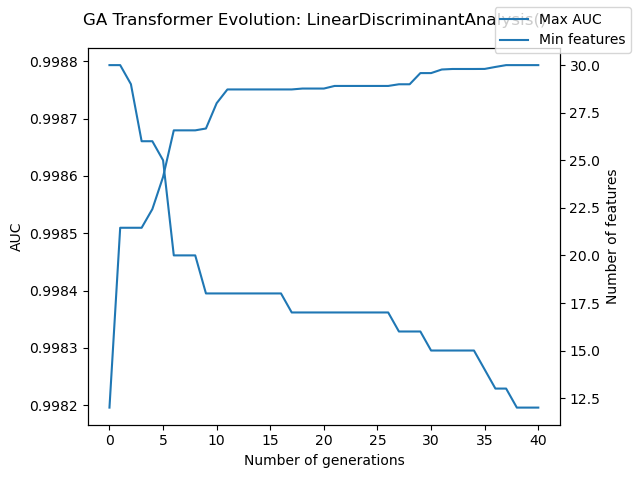

[CV 3/5; 3/30] END classify=GaussianNB(), fs=GATransformer(model=LinearDiscriminantAnalysis()); accuracy: (test=0.988) n_features_in: (test=14.000) precision: (test=0.985) recall: (test=0.976) roc_auc_score: (test=1.000) total time= 5.5min
[CV 4/5; 3/30] START classify=GaussianNB(), fs=GATransformer(model=LinearDiscriminantAnalysis())
   	      	                             auc                              	              n_features              
   	      	--------------------------------------------------------------	--------------------------------------
gen	nevals	gen	max     	mean    	min     	nevals	gen	max	mean	min	nevals
0  	10    	0  	0.997982	0.997541	0.997061	10    	0  	44 	40  	34 	10    
1  	30    	1  	0.998113	0.997905	0.997622	30    	1  	43 	36.8	32 	30    
2  	30    	2  	0.998592	0.998088	0.997764	30    	2  	45 	36.3	32 	30    
3  	30    	3  	0.998619	0.998357	0.997924	30    	3  	38 	33.9	31 	30    
4  	30    	4  	0.998619	0.998466	0.997953	30    	4  	37 	34  	30 	30    

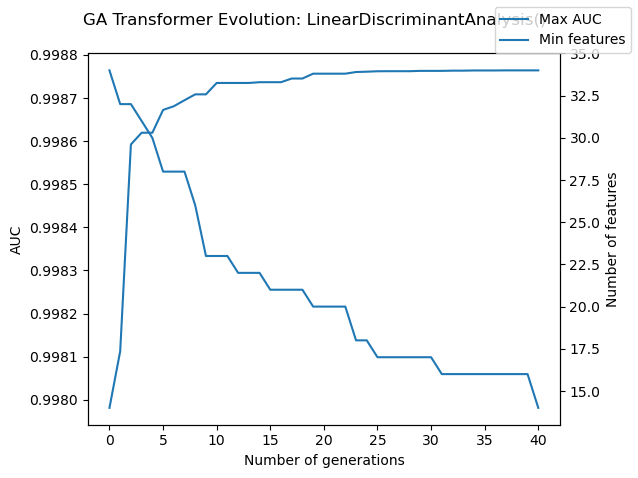

[CV 4/5; 3/30] END classify=GaussianNB(), fs=GATransformer(model=LinearDiscriminantAnalysis()); accuracy: (test=0.982) n_features_in: (test=23.000) precision: (test=0.977) recall: (test=0.971) roc_auc_score: (test=1.000) total time= 6.3min
[CV 5/5; 3/30] START classify=GaussianNB(), fs=GATransformer(model=LinearDiscriminantAnalysis())
   	      	                             auc                              	              n_features              
   	      	--------------------------------------------------------------	--------------------------------------
gen	nevals	gen	max     	mean    	min     	nevals	gen	max	mean	min	nevals
0  	10    	0  	0.998453	0.982729	0.846838	10    	0  	47 	40.5	34 	10    
1  	30    	1  	0.998453	0.998039	0.997559	30    	1  	50 	38.7	34 	30    
2  	30    	2  	0.998531	0.998261	0.997931	30    	2  	42 	36.9	33 	30    
3  	30    	3  	0.998531	0.998288	0.997758	30    	3  	41 	34.6	31 	30    
4  	30    	4  	0.998588	0.998346	0.997572	30    	4  	41 	33.8	27 	30    

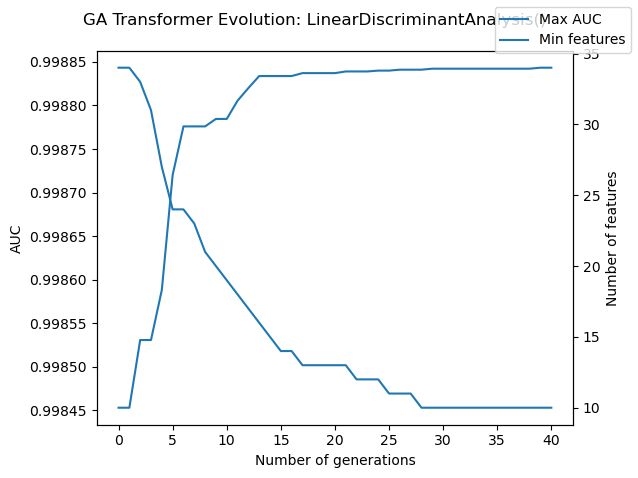

[CV 5/5; 3/30] END classify=GaussianNB(), fs=GATransformer(model=LinearDiscriminantAnalysis()); accuracy: (test=0.997) n_features_in: (test=12.000) precision: (test=0.996) recall: (test=0.994) roc_auc_score: (test=0.999) total time= 5.5min
[CV 1/5; 4/30] START classify=GaussianNB(), fs=SelectFromModel(estimator=LinearDiscriminantAnalysis())
[CV 1/5; 4/30] END classify=GaussianNB(), fs=SelectFromModel(estimator=LinearDiscriminantAnalysis()); accuracy: (test=0.970) n_features_in: (test=6.000) precision: (test=0.966) recall: (test=0.959) roc_auc_score: (test=0.987) total time=   2.1s
[CV 2/5; 4/30] START classify=GaussianNB(), fs=SelectFromModel(estimator=LinearDiscriminantAnalysis())
[CV 2/5; 4/30] END classify=GaussianNB(), fs=SelectFromModel(estimator=LinearDiscriminantAnalysis()); accuracy: (test=0.998) n_features_in: (test=10.000) precision: (test=0.997) recall: (test=0.996) roc_auc_score: (test=1.000) total time=   2.0s
[CV 3/5; 4/30] START classify=GaussianNB(), fs=SelectFromModel(

/home/arisingh/mambaforge/envs/ccd/lib/python3.10/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


[CV 1/5; 7/30] END classify=RandomForestClassifier(), fs=passthrough; accuracy: (test=0.785) n_features_in: (test=81.000) precision: (test=0.643) recall: (test=0.627) roc_auc_score: (test=0.932) total time=   6.6s
[CV 2/5; 7/30] START classify=RandomForestClassifier(), fs=passthrough..........


/home/arisingh/mambaforge/envs/ccd/lib/python3.10/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


[CV 2/5; 7/30] END classify=RandomForestClassifier(), fs=passthrough; accuracy: (test=1.000) n_features_in: (test=81.000) precision: (test=1.000) recall: (test=1.000) roc_auc_score: (test=1.000) total time=   7.0s
[CV 3/5; 7/30] START classify=RandomForestClassifier(), fs=passthrough..........


/home/arisingh/mambaforge/envs/ccd/lib/python3.10/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


[CV 3/5; 7/30] END classify=RandomForestClassifier(), fs=passthrough; accuracy: (test=1.000) n_features_in: (test=81.000) precision: (test=1.000) recall: (test=1.000) roc_auc_score: (test=1.000) total time=   7.1s
[CV 4/5; 7/30] START classify=RandomForestClassifier(), fs=passthrough..........


/home/arisingh/mambaforge/envs/ccd/lib/python3.10/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


[CV 4/5; 7/30] END classify=RandomForestClassifier(), fs=passthrough; accuracy: (test=0.969) n_features_in: (test=81.000) precision: (test=0.961) recall: (test=0.929) roc_auc_score: (test=0.995) total time=   6.9s
[CV 5/5; 7/30] START classify=RandomForestClassifier(), fs=passthrough..........


/home/arisingh/mambaforge/envs/ccd/lib/python3.10/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


[CV 5/5; 7/30] END classify=RandomForestClassifier(), fs=passthrough; accuracy: (test=0.825) n_features_in: (test=81.000) precision: (test=0.826) recall: (test=0.757) roc_auc_score: (test=0.944) total time=   7.2s
[CV 1/5; 8/30] START classify=RandomForestClassifier(), fs=GATransformer(model=GaussianNB())


/home/arisingh/mambaforge/envs/ccd/lib/python3.10/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


[CV 1/5; 8/30] END classify=RandomForestClassifier(), fs=GATransformer(model=GaussianNB()); accuracy: (test=0.737) n_features_in: (test=6.000) precision: (test=0.598) recall: (test=0.555) roc_auc_score: (test=0.910) total time=   4.6s
[CV 2/5; 8/30] START classify=RandomForestClassifier(), fs=GATransformer(model=GaussianNB())


/home/arisingh/mambaforge/envs/ccd/lib/python3.10/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


[CV 2/5; 8/30] END classify=RandomForestClassifier(), fs=GATransformer(model=GaussianNB()); accuracy: (test=1.000) n_features_in: (test=10.000) precision: (test=1.000) recall: (test=1.000) roc_auc_score: (test=1.000) total time=   4.8s
[CV 3/5; 8/30] START classify=RandomForestClassifier(), fs=GATransformer(model=GaussianNB())


/home/arisingh/mambaforge/envs/ccd/lib/python3.10/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


[CV 3/5; 8/30] END classify=RandomForestClassifier(), fs=GATransformer(model=GaussianNB()); accuracy: (test=1.000) n_features_in: (test=9.000) precision: (test=1.000) recall: (test=1.000) roc_auc_score: (test=1.000) total time=   4.8s
[CV 4/5; 8/30] START classify=RandomForestClassifier(), fs=GATransformer(model=GaussianNB())


/home/arisingh/mambaforge/envs/ccd/lib/python3.10/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


[CV 4/5; 8/30] END classify=RandomForestClassifier(), fs=GATransformer(model=GaussianNB()); accuracy: (test=0.973) n_features_in: (test=7.000) precision: (test=0.965) recall: (test=0.928) roc_auc_score: (test=1.000) total time=   4.0s
[CV 5/5; 8/30] START classify=RandomForestClassifier(), fs=GATransformer(model=GaussianNB())


/home/arisingh/mambaforge/envs/ccd/lib/python3.10/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


[CV 5/5; 8/30] END classify=RandomForestClassifier(), fs=GATransformer(model=GaussianNB()); accuracy: (test=0.819) n_features_in: (test=11.000) precision: (test=0.807) recall: (test=0.749) roc_auc_score: (test=0.935) total time=   4.9s
[CV 1/5; 9/30] START classify=RandomForestClassifier(), fs=GATransformer(model=LinearDiscriminantAnalysis())


/home/arisingh/mambaforge/envs/ccd/lib/python3.10/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


[CV 1/5; 9/30] END classify=RandomForestClassifier(), fs=GATransformer(model=LinearDiscriminantAnalysis()); accuracy: (test=0.742) n_features_in: (test=6.000) precision: (test=0.584) recall: (test=0.568) roc_auc_score: (test=0.947) total time=   4.8s
[CV 2/5; 9/30] START classify=RandomForestClassifier(), fs=GATransformer(model=LinearDiscriminantAnalysis())


/home/arisingh/mambaforge/envs/ccd/lib/python3.10/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


[CV 2/5; 9/30] END classify=RandomForestClassifier(), fs=GATransformer(model=LinearDiscriminantAnalysis()); accuracy: (test=1.000) n_features_in: (test=8.000) precision: (test=1.000) recall: (test=1.000) roc_auc_score: (test=1.000) total time=   4.9s
[CV 3/5; 9/30] START classify=RandomForestClassifier(), fs=GATransformer(model=LinearDiscriminantAnalysis())


/home/arisingh/mambaforge/envs/ccd/lib/python3.10/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


[CV 3/5; 9/30] END classify=RandomForestClassifier(), fs=GATransformer(model=LinearDiscriminantAnalysis()); accuracy: (test=1.000) n_features_in: (test=14.000) precision: (test=1.000) recall: (test=1.000) roc_auc_score: (test=1.000) total time=   5.0s
[CV 4/5; 9/30] START classify=RandomForestClassifier(), fs=GATransformer(model=LinearDiscriminantAnalysis())


/home/arisingh/mambaforge/envs/ccd/lib/python3.10/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


[CV 4/5; 9/30] END classify=RandomForestClassifier(), fs=GATransformer(model=LinearDiscriminantAnalysis()); accuracy: (test=0.974) n_features_in: (test=23.000) precision: (test=0.966) recall: (test=0.932) roc_auc_score: (test=0.999) total time=   5.2s
[CV 5/5; 9/30] START classify=RandomForestClassifier(), fs=GATransformer(model=LinearDiscriminantAnalysis())


/home/arisingh/mambaforge/envs/ccd/lib/python3.10/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


[CV 5/5; 9/30] END classify=RandomForestClassifier(), fs=GATransformer(model=LinearDiscriminantAnalysis()); accuracy: (test=0.835) n_features_in: (test=12.000) precision: (test=0.818) recall: (test=0.757) roc_auc_score: (test=0.968) total time=   5.0s
[CV 1/5; 10/30] START classify=RandomForestClassifier(), fs=SelectFromModel(estimator=LinearDiscriminantAnalysis())


/home/arisingh/mambaforge/envs/ccd/lib/python3.10/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


[CV 1/5; 10/30] END classify=RandomForestClassifier(), fs=SelectFromModel(estimator=LinearDiscriminantAnalysis()); accuracy: (test=0.716) n_features_in: (test=6.000) precision: (test=0.562) recall: (test=0.520) roc_auc_score: (test=0.963) total time=   4.7s
[CV 2/5; 10/30] START classify=RandomForestClassifier(), fs=SelectFromModel(estimator=LinearDiscriminantAnalysis())


/home/arisingh/mambaforge/envs/ccd/lib/python3.10/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


[CV 2/5; 10/30] END classify=RandomForestClassifier(), fs=SelectFromModel(estimator=LinearDiscriminantAnalysis()); accuracy: (test=1.000) n_features_in: (test=10.000) precision: (test=1.000) recall: (test=1.000) roc_auc_score: (test=1.000) total time=   4.8s
[CV 3/5; 10/30] START classify=RandomForestClassifier(), fs=SelectFromModel(estimator=LinearDiscriminantAnalysis())


/home/arisingh/mambaforge/envs/ccd/lib/python3.10/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


[CV 3/5; 10/30] END classify=RandomForestClassifier(), fs=SelectFromModel(estimator=LinearDiscriminantAnalysis()); accuracy: (test=1.000) n_features_in: (test=6.000) precision: (test=1.000) recall: (test=1.000) roc_auc_score: (test=1.000) total time=   4.6s
[CV 4/5; 10/30] START classify=RandomForestClassifier(), fs=SelectFromModel(estimator=LinearDiscriminantAnalysis())


/home/arisingh/mambaforge/envs/ccd/lib/python3.10/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


[CV 4/5; 10/30] END classify=RandomForestClassifier(), fs=SelectFromModel(estimator=LinearDiscriminantAnalysis()); accuracy: (test=0.974) n_features_in: (test=8.000) precision: (test=0.967) recall: (test=0.935) roc_auc_score: (test=0.999) total time=   4.6s
[CV 5/5; 10/30] START classify=RandomForestClassifier(), fs=SelectFromModel(estimator=LinearDiscriminantAnalysis())


/home/arisingh/mambaforge/envs/ccd/lib/python3.10/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


[CV 5/5; 10/30] END classify=RandomForestClassifier(), fs=SelectFromModel(estimator=LinearDiscriminantAnalysis()); accuracy: (test=0.883) n_features_in: (test=6.000) precision: (test=0.850) recall: (test=0.769) roc_auc_score: (test=0.981) total time=   4.6s
[CV 1/5; 11/30] START classify=RandomForestClassifier(), fs=SelectFromModel(estimator=RandomForestClassifier(max_depth=3, n_estimators=150))


/home/arisingh/mambaforge/envs/ccd/lib/python3.10/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


[CV 1/5; 11/30] END classify=RandomForestClassifier(), fs=SelectFromModel(estimator=RandomForestClassifier(max_depth=3, n_estimators=150)); accuracy: (test=0.806) n_features_in: (test=8.000) precision: (test=0.673) recall: (test=0.667) roc_auc_score: (test=0.933) total time=   5.0s
[CV 2/5; 11/30] START classify=RandomForestClassifier(), fs=SelectFromModel(estimator=RandomForestClassifier(max_depth=3, n_estimators=150))


/home/arisingh/mambaforge/envs/ccd/lib/python3.10/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


[CV 2/5; 11/30] END classify=RandomForestClassifier(), fs=SelectFromModel(estimator=RandomForestClassifier(max_depth=3, n_estimators=150)); accuracy: (test=1.000) n_features_in: (test=10.000) precision: (test=1.000) recall: (test=1.000) roc_auc_score: (test=1.000) total time=   4.9s
[CV 3/5; 11/30] START classify=RandomForestClassifier(), fs=SelectFromModel(estimator=RandomForestClassifier(max_depth=3, n_estimators=150))


/home/arisingh/mambaforge/envs/ccd/lib/python3.10/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


[CV 3/5; 11/30] END classify=RandomForestClassifier(), fs=SelectFromModel(estimator=RandomForestClassifier(max_depth=3, n_estimators=150)); accuracy: (test=1.000) n_features_in: (test=10.000) precision: (test=1.000) recall: (test=1.000) roc_auc_score: (test=1.000) total time=   4.8s
[CV 4/5; 11/30] START classify=RandomForestClassifier(), fs=SelectFromModel(estimator=RandomForestClassifier(max_depth=3, n_estimators=150))


/home/arisingh/mambaforge/envs/ccd/lib/python3.10/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


[CV 4/5; 11/30] END classify=RandomForestClassifier(), fs=SelectFromModel(estimator=RandomForestClassifier(max_depth=3, n_estimators=150)); accuracy: (test=0.969) n_features_in: (test=10.000) precision: (test=0.960) recall: (test=0.928) roc_auc_score: (test=0.995) total time=   4.8s
[CV 5/5; 11/30] START classify=RandomForestClassifier(), fs=SelectFromModel(estimator=RandomForestClassifier(max_depth=3, n_estimators=150))


/home/arisingh/mambaforge/envs/ccd/lib/python3.10/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


[CV 5/5; 11/30] END classify=RandomForestClassifier(), fs=SelectFromModel(estimator=RandomForestClassifier(max_depth=3, n_estimators=150)); accuracy: (test=0.834) n_features_in: (test=10.000) precision: (test=0.816) recall: (test=0.755) roc_auc_score: (test=0.936) total time=   4.7s
[CV 1/5; 12/30] START classify=RandomForestClassifier(), fs=SelectFromModel(estimator=XGBClassifier(base_score=None, booster=None,
                                        callbacks=None, colsample_bylevel=None,
                                        colsample_bynode=None,
                                        colsample_bytree=None,
                                        early_stopping_rounds=None,
                                        enable_categorical=False,
                                        eval_metric='logloss',
                                        feature_types=None, gamma=None,
                                        gpu_id=None, grow_policy=None,
                                       

/home/arisingh/mambaforge/envs/ccd/lib/python3.10/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


[CV 1/5; 12/30] END classify=RandomForestClassifier(), fs=SelectFromModel(estimator=XGBClassifier(base_score=None, booster=None,
                                        callbacks=None, colsample_bylevel=None,
                                        colsample_bynode=None,
                                        colsample_bytree=None,
                                        early_stopping_rounds=None,
                                        enable_categorical=False,
                                        eval_metric='logloss',
                                        feature_types=None, gamma=None,
                                        gpu_id=None, grow_policy=None,
                                        importance_type=None,
                                        interaction_constraints=None,
                                        learning_rate=0.1, max_bin=None,
                                        max_cat_threshold=None,
                                        max_cat_to_oneho

/home/arisingh/mambaforge/envs/ccd/lib/python3.10/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


[CV 2/5; 12/30] END classify=RandomForestClassifier(), fs=SelectFromModel(estimator=XGBClassifier(base_score=None, booster=None,
                                        callbacks=None, colsample_bylevel=None,
                                        colsample_bynode=None,
                                        colsample_bytree=None,
                                        early_stopping_rounds=None,
                                        enable_categorical=False,
                                        eval_metric='logloss',
                                        feature_types=None, gamma=None,
                                        gpu_id=None, grow_policy=None,
                                        importance_type=None,
                                        interaction_constraints=None,
                                        learning_rate=0.1, max_bin=None,
                                        max_cat_threshold=None,
                                        max_cat_to_oneho

/home/arisingh/mambaforge/envs/ccd/lib/python3.10/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


[CV 3/5; 12/30] END classify=RandomForestClassifier(), fs=SelectFromModel(estimator=XGBClassifier(base_score=None, booster=None,
                                        callbacks=None, colsample_bylevel=None,
                                        colsample_bynode=None,
                                        colsample_bytree=None,
                                        early_stopping_rounds=None,
                                        enable_categorical=False,
                                        eval_metric='logloss',
                                        feature_types=None, gamma=None,
                                        gpu_id=None, grow_policy=None,
                                        importance_type=None,
                                        interaction_constraints=None,
                                        learning_rate=0.1, max_bin=None,
                                        max_cat_threshold=None,
                                        max_cat_to_oneho

/home/arisingh/mambaforge/envs/ccd/lib/python3.10/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


[CV 4/5; 12/30] END classify=RandomForestClassifier(), fs=SelectFromModel(estimator=XGBClassifier(base_score=None, booster=None,
                                        callbacks=None, colsample_bylevel=None,
                                        colsample_bynode=None,
                                        colsample_bytree=None,
                                        early_stopping_rounds=None,
                                        enable_categorical=False,
                                        eval_metric='logloss',
                                        feature_types=None, gamma=None,
                                        gpu_id=None, grow_policy=None,
                                        importance_type=None,
                                        interaction_constraints=None,
                                        learning_rate=0.1, max_bin=None,
                                        max_cat_threshold=None,
                                        max_cat_to_oneho

/home/arisingh/mambaforge/envs/ccd/lib/python3.10/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


[CV 5/5; 12/30] END classify=RandomForestClassifier(), fs=SelectFromModel(estimator=XGBClassifier(base_score=None, booster=None,
                                        callbacks=None, colsample_bylevel=None,
                                        colsample_bynode=None,
                                        colsample_bytree=None,
                                        early_stopping_rounds=None,
                                        enable_categorical=False,
                                        eval_metric='logloss',
                                        feature_types=None, gamma=None,
                                        gpu_id=None, grow_policy=None,
                                        importance_type=None,
                                        interaction_constraints=None,
                                        learning_rate=0.1, max_bin=None,
                                        max_cat_threshold=None,
                                        max_cat_to_oneho

/home/arisingh/mambaforge/envs/ccd/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 1/5; 20/30] END classify=LinearSVC(), fs=GATransformer(model=GaussianNB()); accuracy: (test=0.864) n_features_in: (test=6.000) precision: (test=0.747) recall: (test=0.671) roc_auc_score: (test=0.981) total time=   0.5s
[CV 2/5; 20/30] START classify=LinearSVC(), fs=GATransformer(model=GaussianNB())
[CV 2/5; 20/30] END classify=LinearSVC(), fs=GATransformer(model=GaussianNB()); accuracy: (test=0.841) n_features_in: (test=10.000) precision: (test=0.677) recall: (test=0.669) roc_auc_score: (test=0.970) total time=   0.9s
[CV 3/5; 20/30] START classify=LinearSVC(), fs=GATransformer(model=GaussianNB())


/home/arisingh/mambaforge/envs/ccd/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 3/5; 20/30] END classify=LinearSVC(), fs=GATransformer(model=GaussianNB()); accuracy: (test=0.863) n_features_in: (test=9.000) precision: (test=0.580) recall: (test=0.667) roc_auc_score: (test=0.975) total time=   0.8s
[CV 4/5; 20/30] START classify=LinearSVC(), fs=GATransformer(model=GaussianNB())


/home/arisingh/mambaforge/envs/ccd/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 4/5; 20/30] END classify=LinearSVC(), fs=GATransformer(model=GaussianNB()); accuracy: (test=0.863) n_features_in: (test=7.000) precision: (test=0.558) recall: (test=0.667) roc_auc_score: (test=0.978) total time=   0.6s
[CV 5/5; 20/30] START classify=LinearSVC(), fs=GATransformer(model=GaussianNB())


/home/arisingh/mambaforge/envs/ccd/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 5/5; 20/30] END classify=LinearSVC(), fs=GATransformer(model=GaussianNB()); accuracy: (test=0.838) n_features_in: (test=11.000) precision: (test=0.611) recall: (test=0.664) roc_auc_score: (test=0.971) total time=   0.6s
[CV 1/5; 21/30] START classify=LinearSVC(), fs=GATransformer(model=LinearDiscriminantAnalysis())
[CV 1/5; 21/30] END classify=LinearSVC(), fs=GATransformer(model=LinearDiscriminantAnalysis()); accuracy: (test=0.861) n_features_in: (test=6.000) precision: (test=0.710) recall: (test=0.666) roc_auc_score: (test=0.978) total time=   0.6s
[CV 2/5; 21/30] START classify=LinearSVC(), fs=GATransformer(model=LinearDiscriminantAnalysis())
[CV 2/5; 21/30] END classify=LinearSVC(), fs=GATransformer(model=LinearDiscriminantAnalysis()); accuracy: (test=0.843) n_features_in: (test=8.000) precision: (test=0.692) recall: (test=0.663) roc_auc_score: (test=0.970) total time=   0.5s
[CV 3/5; 21/30] START classify=LinearSVC(), fs=GATransformer(model=LinearDiscriminantAnalysis())
[CV 3/5

/home/arisingh/mambaforge/envs/ccd/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 1/5; 22/30] END classify=LinearSVC(), fs=SelectFromModel(estimator=LinearDiscriminantAnalysis()); accuracy: (test=0.863) n_features_in: (test=6.000) precision: (test=0.580) recall: (test=0.667) roc_auc_score: (test=0.977) total time=   0.9s
[CV 2/5; 22/30] START classify=LinearSVC(), fs=SelectFromModel(estimator=LinearDiscriminantAnalysis())


/home/arisingh/mambaforge/envs/ccd/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 2/5; 22/30] END classify=LinearSVC(), fs=SelectFromModel(estimator=LinearDiscriminantAnalysis()); accuracy: (test=0.863) n_features_in: (test=10.000) precision: (test=0.580) recall: (test=0.667) roc_auc_score: (test=0.979) total time=   0.7s
[CV 3/5; 22/30] START classify=LinearSVC(), fs=SelectFromModel(estimator=LinearDiscriminantAnalysis())


/home/arisingh/mambaforge/envs/ccd/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 3/5; 22/30] END classify=LinearSVC(), fs=SelectFromModel(estimator=LinearDiscriminantAnalysis()); accuracy: (test=0.863) n_features_in: (test=6.000) precision: (test=0.579) recall: (test=0.667) roc_auc_score: (test=0.977) total time=   0.8s
[CV 4/5; 22/30] START classify=LinearSVC(), fs=SelectFromModel(estimator=LinearDiscriminantAnalysis())


/home/arisingh/mambaforge/envs/ccd/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 4/5; 22/30] END classify=LinearSVC(), fs=SelectFromModel(estimator=LinearDiscriminantAnalysis()); accuracy: (test=0.863) n_features_in: (test=8.000) precision: (test=0.580) recall: (test=0.667) roc_auc_score: (test=0.979) total time=   0.6s
[CV 5/5; 22/30] START classify=LinearSVC(), fs=SelectFromModel(estimator=LinearDiscriminantAnalysis())


/home/arisingh/mambaforge/envs/ccd/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 5/5; 22/30] END classify=LinearSVC(), fs=SelectFromModel(estimator=LinearDiscriminantAnalysis()); accuracy: (test=0.863) n_features_in: (test=6.000) precision: (test=0.580) recall: (test=0.667) roc_auc_score: (test=0.977) total time=   1.0s
[CV 1/5; 23/30] START classify=LinearSVC(), fs=SelectFromModel(estimator=RandomForestClassifier(max_depth=3, n_estimators=150))


/home/arisingh/mambaforge/envs/ccd/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 1/5; 23/30] END classify=LinearSVC(), fs=SelectFromModel(estimator=RandomForestClassifier(max_depth=3, n_estimators=150)); accuracy: (test=0.858) n_features_in: (test=8.000) precision: (test=0.572) recall: (test=0.659) roc_auc_score: (test=0.975) total time=   1.0s
[CV 2/5; 23/30] START classify=LinearSVC(), fs=SelectFromModel(estimator=RandomForestClassifier(max_depth=3, n_estimators=150))
[CV 2/5; 23/30] END classify=LinearSVC(), fs=SelectFromModel(estimator=RandomForestClassifier(max_depth=3, n_estimators=150)); accuracy: (test=0.855) n_features_in: (test=10.000) precision: (test=0.671) recall: (test=0.674) roc_auc_score: (test=0.970) total time=   0.8s
[CV 3/5; 23/30] START classify=LinearSVC(), fs=SelectFromModel(estimator=RandomForestClassifier(max_depth=3, n_estimators=150))
[CV 3/5; 23/30] END classify=LinearSVC(), fs=SelectFromModel(estimator=RandomForestClassifier(max_depth=3, n_estimators=150)); accuracy: (test=0.860) n_features_in: (test=10.000) precision: (test=0.771) 

/home/arisingh/mambaforge/envs/ccd/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 5/5; 23/30] END classify=LinearSVC(), fs=SelectFromModel(estimator=RandomForestClassifier(max_depth=3, n_estimators=150)); accuracy: (test=0.834) n_features_in: (test=10.000) precision: (test=0.545) recall: (test=0.629) roc_auc_score: (test=0.977) total time=   0.8s
[CV 1/5; 24/30] START classify=LinearSVC(), fs=SelectFromModel(estimator=XGBClassifier(base_score=None, booster=None,
                                        callbacks=None, colsample_bylevel=None,
                                        colsample_bynode=None,
                                        colsample_bytree=None,
                                        early_stopping_rounds=None,
                                        enable_categorical=False,
                                        eval_metric='logloss',
                                        feature_types=None, gamma=None,
                                        gpu_id=None, grow_policy=None,
                                        importance_type=None,
   

/home/arisingh/mambaforge/envs/ccd/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 1/5; 24/30] END classify=LinearSVC(), fs=SelectFromModel(estimator=XGBClassifier(base_score=None, booster=None,
                                        callbacks=None, colsample_bylevel=None,
                                        colsample_bynode=None,
                                        colsample_bytree=None,
                                        early_stopping_rounds=None,
                                        enable_categorical=False,
                                        eval_metric='logloss',
                                        feature_types=None, gamma=None,
                                        gpu_id=None, grow_policy=None,
                                        importance_type=None,
                                        interaction_constraints=None,
                                        learning_rate=0.1, max_bin=None,
                                        max_cat_threshold=None,
                                        max_cat_to_onehot=None,
     

/home/arisingh/mambaforge/envs/ccd/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 2/5; 24/30] END classify=LinearSVC(), fs=SelectFromModel(estimator=XGBClassifier(base_score=None, booster=None,
                                        callbacks=None, colsample_bylevel=None,
                                        colsample_bynode=None,
                                        colsample_bytree=None,
                                        early_stopping_rounds=None,
                                        enable_categorical=False,
                                        eval_metric='logloss',
                                        feature_types=None, gamma=None,
                                        gpu_id=None, grow_policy=None,
                                        importance_type=None,
                                        interaction_constraints=None,
                                        learning_rate=0.1, max_bin=None,
                                        max_cat_threshold=None,
                                        max_cat_to_onehot=None,
     

/home/arisingh/mambaforge/envs/ccd/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 3/5; 24/30] END classify=LinearSVC(), fs=SelectFromModel(estimator=XGBClassifier(base_score=None, booster=None,
                                        callbacks=None, colsample_bylevel=None,
                                        colsample_bynode=None,
                                        colsample_bytree=None,
                                        early_stopping_rounds=None,
                                        enable_categorical=False,
                                        eval_metric='logloss',
                                        feature_types=None, gamma=None,
                                        gpu_id=None, grow_policy=None,
                                        importance_type=None,
                                        interaction_constraints=None,
                                        learning_rate=0.1, max_bin=None,
                                        max_cat_threshold=None,
                                        max_cat_to_onehot=None,
     

/home/arisingh/mambaforge/envs/ccd/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 4/5; 24/30] END classify=LinearSVC(), fs=SelectFromModel(estimator=XGBClassifier(base_score=None, booster=None,
                                        callbacks=None, colsample_bylevel=None,
                                        colsample_bynode=None,
                                        colsample_bytree=None,
                                        early_stopping_rounds=None,
                                        enable_categorical=False,
                                        eval_metric='logloss',
                                        feature_types=None, gamma=None,
                                        gpu_id=None, grow_policy=None,
                                        importance_type=None,
                                        interaction_constraints=None,
                                        learning_rate=0.1, max_bin=None,
                                        max_cat_threshold=None,
                                        max_cat_to_onehot=None,
     

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(memory='cache',
                                steps=[('scaling', StandardScaler()),
                                       ('fs', 'passthrough'),
                                       ('classify', GaussianNB())]),
             param_grid=[{'classify': [GaussianNB(), RandomForestClassifier(),
                                       LogisticRegression(), LinearSVC(),
                                       KNeighborsClassifier()],
                          'fs': ['passthrough',
                                 GATransformer(model=GaussianNB()),
                                 GATransformer(model...
                                                                         learning_rate=0.1,
                                                                         max_bin=None,
                                                                         max_cat_threshold=None,
                                                                         max_cat_to_onehot=None,
                                                                         max_delta_step=None,
                                                                         max_depth=3,
                                                                         max_leaves=None,
                                                                         min_child_weight=None,
                                                                         missing=nan,
                                                                         monotone_constraints=None,
                                                                         n_estimators=150,
                                                                         n_jobs=None,
                                                                         num_parallel_tree=None,
                                                                         predictor=None,
                                                                         random_state=None, ...))]}],
             refit=False, scoring=<function custom_scorer at 0x7f199fcd1bd0>,
             verbose=10)

In [6]:
classifier = skNB()
scaler = StandardScaler()
pipe = Pipeline(
    [
        ("scaling", scaler),
        ("fs", "passthrough"),
        ("classify", classifier)
    ],
    memory="cache"
)

param_grid = [
    {
        "fs": ["passthrough",
               GATransformer(model=skNB()),
               GATransformer(model=skLDA()),
               SelectFromModel(estimator=skLDA()),
               SelectFromModel(estimator=skRF(n_estimators = 150, 
                                                 max_depth = 3)),
               SelectFromModel(estimator=XGBClassifier(n_estimators = 150,
                           max_depth = 3,
                           learning_rate = 0.1,
                           verbose=None,
                           tree_method='gpu_hist',
                           eval_metric='logloss'))],
        "classify": [skNB(),
                           cuRF(n_estimators = 500,
                                                 max_features=1.0),
                           cuLR(),
                           cuSVC(probability=True),
                           cuKNN(n_neighbors=17)]
    }
]

search = GridSearchCV(pipe, param_grid, scoring=custom_scorer, refit=False, cv=5, verbose=10, error_score='raise')
search.fit(X_data, y_data)

In [7]:
search_scores = search.cv_results_
for params, acc, rank, features_in in zip(search_scores['params'], 
                                          search_scores['mean_test_accuracy'], 
                                          search_scores['rank_test_accuracy'], 
                                          search_scores['mean_test_n_features_in']):
    print("params:", params, "accuracy:", acc, "rank:", rank, "features selected:", features_in)

params: {'classify': GaussianNB(), 'fs': 'passthrough'} accuracy: 0.9898107238313424 rank: 7 features selected: 81.0
params: {'classify': GaussianNB(), 'fs': GATransformer(model=GaussianNB())} accuracy: 0.9919816723940436 rank: 6 features selected: 8.6
params: {'classify': GaussianNB(), 'fs': GATransformer(model=LinearDiscriminantAnalysis())} accuracy: 0.988774341351661 rank: 8 features selected: 12.6
params: {'classify': GaussianNB(), 'fs': SelectFromModel(estimator=LinearDiscriminantAnalysis())} accuracy: 0.9927125947744504 rank: 5 features selected: 7.2
params: {'classify': GaussianNB(), 'fs': SelectFromModel(estimator=RandomForestClassifier(max_depth=3, n_estimators=150))} accuracy: 0.9939562537500682 rank: 3 features selected: 9.6
params: {'classify': GaussianNB(), 'fs': SelectFromModel(estimator=XGBClassifier(base_score=None, booster=None,
                                        callbacks=None, colsample_bylevel=None,
                                        colsample_bynode=None,

In [8]:
scores_df = pd.DataFrame(search.cv_results_)
scores_df.to_csv("ccd_inid_scores.csv")